# dts data reading preprocessing and filling missing data
### the excel file was splited to forwrd and backwrd csv files based on the original sheets names

In [1]:
import pandas as pd 
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
forwrd=pd.read_csv("DATA/aramco/data/DTSV_data_gaps.csv",'|')
forwrd=forwrd.melt(id_vars=['Depth (m)'], var_name='time', value_name='temperature')
backwrd=pd.read_csv("DATA/aramco/data/DTSV_data_gaps2.csv",'|')
backwrd=backwrd.melt(id_vars=['Depth (m)'], var_name='time', value_name='temperature')

# data visualisation
### we took one example of Depth ...


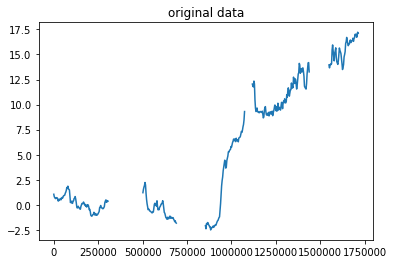

In [115]:
#showing original data
forwrd[forwrd['Depth (m)']==2.2769999999999997].temperature.plot(title='original data')

# making some basic intrpolation to fill the missed values

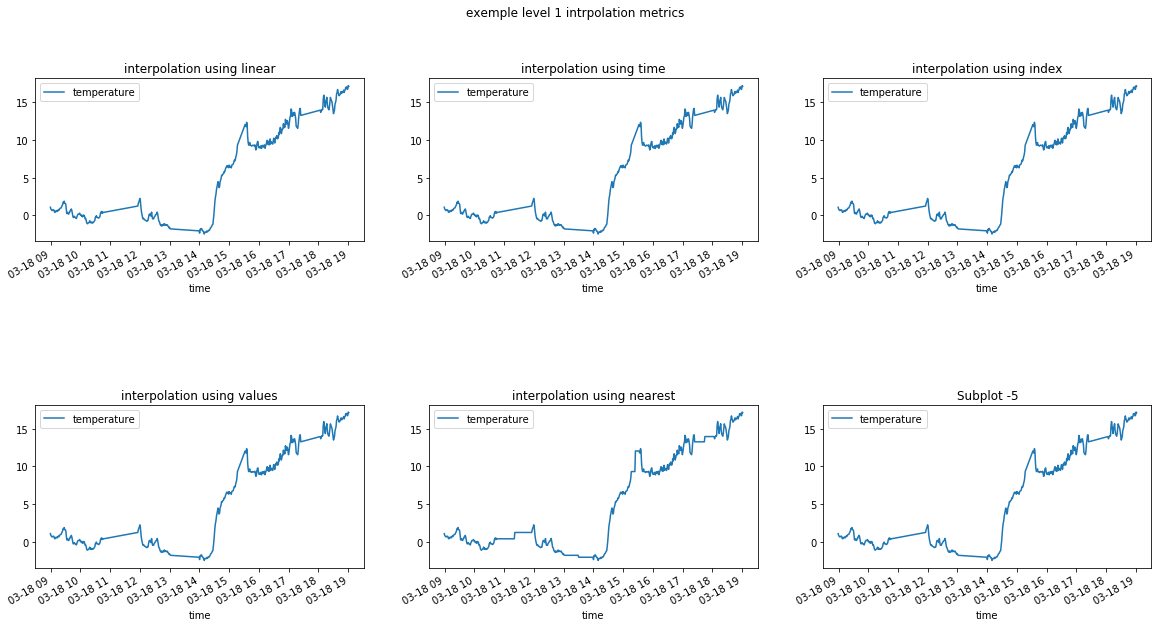

In [112]:
level1=['linear', 'time', 'index', 'values', 'nearest', 'slinear' ]
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=1)
fig.suptitle('exemple level 1 intrpolation metrics')
for i in range(len(level1)):
    df.interpolate(method=level1[i],order=2).plot(title='interpolation using '+level1[i],ax=axes.flatten()[i],figsize=(20,10))
    plt.title('Subplot -' + str(i))


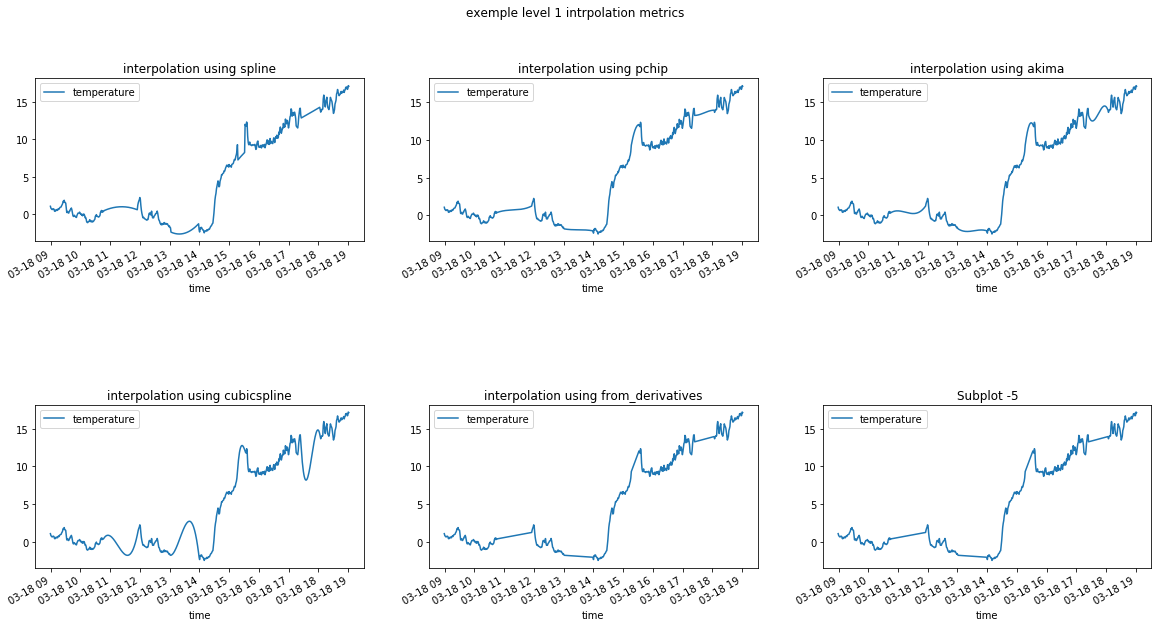

In [111]:
level2=['spline', 'pchip','akima', 'cubicspline','from_derivatives','piecewise_polynomial']
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=1)
fig.suptitle('exemple level 1 intrpolation metrics')
for i in range(len(level2)):
    df.interpolate(method=level2[i],order=2).plot(title='interpolation using '+level2[i],ax=axes.flatten()[i],figsize=(20,10))
    plt.title('Subplot -' + str(i))


### ------------------------------------------------------------------------------------------------------------------------------------
# predicting the missed value using roolback window
### first preprocessing..

In [2]:
def rollback(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


### using parallelisation to deacrese processing time


In [3]:
import multiprocessing
import numpy as np
import pandas as pd
window_size=5
num_cores = multiprocessing.cpu_count()
def processInput(i):
    return rollback(forwrd[forwrd['Depth (m)']==i][['temperature']], n_in=window_size, n_out=1, dropnan=True)
data=pd.DataFrame()
df_chunks=forwrd['Depth (m)'].drop_duplicates()
with multiprocessing.Pool(num_cores) as pool:
  data = pd.concat(pool.map(processInput, df_chunks), ignore_index=True)
data

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,0.933,0.821,0.582,0.755,0.623,0.739
1,0.821,0.582,0.755,0.623,0.739,0.795
2,0.582,0.755,0.623,0.739,0.795,0.664
3,0.755,0.623,0.739,0.795,0.664,0.692
4,0.623,0.739,0.795,0.664,0.692,0.377
...,...,...,...,...,...,...
1138775,100.660,99.604,99.428,99.345,99.512,99.284
1138776,99.604,99.428,99.345,99.512,99.284,98.980
1138777,99.428,99.345,99.512,99.284,98.980,98.931
1138778,99.345,99.512,99.284,98.980,98.931,99.205


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['var1(t)'],axis=1),data[['var1(t)']], test_size=0.2, random_state=42)
interpolation = RandomForestRegressor(n_estimators=10,n_jobs=-1)
interpolation.fit(X_train,y_train)
print('score for testing',interpolation.score(X_test,y_test))

/home/othmanekada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


score for testing 0.9998799879133121


## drawing interpolation results from RandomForestRegressor

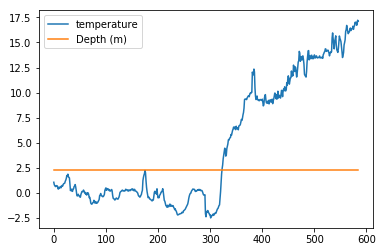

In [86]:
def predicter(input_df,depth,window_size,model):
    tmp=input_df[input_df['Depth (m)']==depth]['temperature'].reset_index(drop=True).values.tolist().copy()
    for i in sum(np.argwhere(np.isnan(tmp)).tolist(),[]): 
        tmp[i]=model.predict(np.array(tmp[i-window_size:i]).reshape(1, -1))[0]
    result=pd.DataFrame(tmp,columns=['temperature'])
    result['Depth (m)']=depth
    result['time']=input_df[input_df['Depth (m)']==depth]['time'].reset_index(drop=True).values
    return result
predicter(forwrd,2.2769999999999997,window_size,interpolation).plot()

### ------------------------------------------------------------------------------------------------------------------------------------

## prediction all the missed data


In [87]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
forwrd_results=pd.DataFrame()
df_chunks=forwrd['Depth (m)'].drop_duplicates()
def predicter_paralel(i):
    return predicter(forwrd,i,window_size,interpolation)                        
with multiprocessing.Pool(num_cores) as pool:
    forwrd_results = pd.concat(pool.map(predicter_paralel, df_chunks), ignore_index=True)

In [91]:
forwrd_results.pivot_table(index='Depth (m)',
                           columns='time', 
                           values='temperature').to_csv(
                            '/home/othmanekada/DATA/aramco/output/dts/forwrd.csv',
index=False)

In [92]:
backwrd_results=pd.DataFrame()
df_chunks=backwrd['Depth (m)'].drop_duplicates()
def predicter_paralel(i):
    return predicter(backwrd,i,window_size,interpolation)                        
with multiprocessing.Pool(num_cores) as pool:
    backwrd_results = pd.concat(pool.map(predicter_paralel, df_chunks), ignore_index=True)

In [94]:
backwrd.pivot_table(index='Depth (m)',
                           columns='time', 
                           values='temperature').to_csv(
                            'DATA/aramco/output/dts/backwrd.csv',
index=False)